In [56]:
import os
from PIL import Image
import itertools

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

print('Modules loaded successfully')

Modules loaded successfully


### Preprocessing

***Read data and store it in dataframe***

In [3]:

data_dir = 'C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-weather-dataset/Multi-class Weather Dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    # print(fold)
    foldpath = os.path.join(data_dir, fold)
    # print(foldpath)
    
    pics = os.listdir(foldpath)
    for pic in pics:
        # print(pic)
        pic_path = os.path.join(foldpath, pic)
        # print(pic_path)
        
        filepaths.append(pic_path)
        labels.append(fold)
        
        
FSeries = pd.Series(filepaths, name='Pic Path')
LSeries = pd.Series(labels, name='Labels')

df = pd.concat([FSeries, LSeries], axis=1)

In [4]:
df

,Pic Path,Labels
0,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Cloudy
1,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Cloudy
2,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Cloudy
3,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Cloudy
4,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Cloudy
...,...,...
1120,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Sunrise
1121,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Sunrise
1122,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Sunrise
1123,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Sunrise


***Spliting Dataframe into train, valid, test***

In [5]:
train_df, dummy_df = train_test_split(df, test_size=0.25, random_state=42, stratify=df['Labels'])
test_df,  valid_df= train_test_split(dummy_df, test_size=0.5, random_state=42, stratify=dummy_df['Labels'])

In [6]:
train_df


,Pic Path,Labels
782,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Sunrise
399,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Rain
224,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Cloudy
421,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Rain
940,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Sunrise
...,...,...
38,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Cloudy
1050,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Sunrise
168,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Cloudy
444,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Rain


In [7]:
test_df


,Pic Path,Labels
398,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Rain
360,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Rain
460,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Rain
415,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Rain
21,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Cloudy
...,...,...
634,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Shine
880,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Sunrise
1024,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Sunrise
626,C:/Users/zizaM/OneDrive/سطح المكتب/multiclass-...,Shine


In [8]:
from keras.preprocessing.image import ImageDataGenerator



# Batch size and image size
batch_size = 16
img_size = (224, 224)
batch_size = 16
img_size = (224, 224)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col='Pic Path', y_col='Labels',target_size= img_size, 
                                   class_mode= 'categorical', color_mode='rgb', shuffle = True,rotation_range=90,
    horizontal_flip=True, vertical_flip=True ,batch_size= batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='Pic Path', y_col='Labels',target_size= img_size, 
                                   class_mode= 'categorical', color_mode='rgb', shuffle = True,rotation_range=90,
    horizontal_flip=True, vertical_flip=True ,
                                   batch_size= batch_size)

test_gen = gen.flow_from_dataframe(test_df, x_col='Pic Path', y_col='Labels',target_size= img_size, 
                                   class_mode= 'categorical', color_mode='rgb', shuffle = False,
                                   batch_size= batch_size)

Found 843 validated image filenames belonging to 4 classes.
Found 141 validated image filenames belonging to 4 classes.
Found 141 validated image filenames belonging to 4 classes.


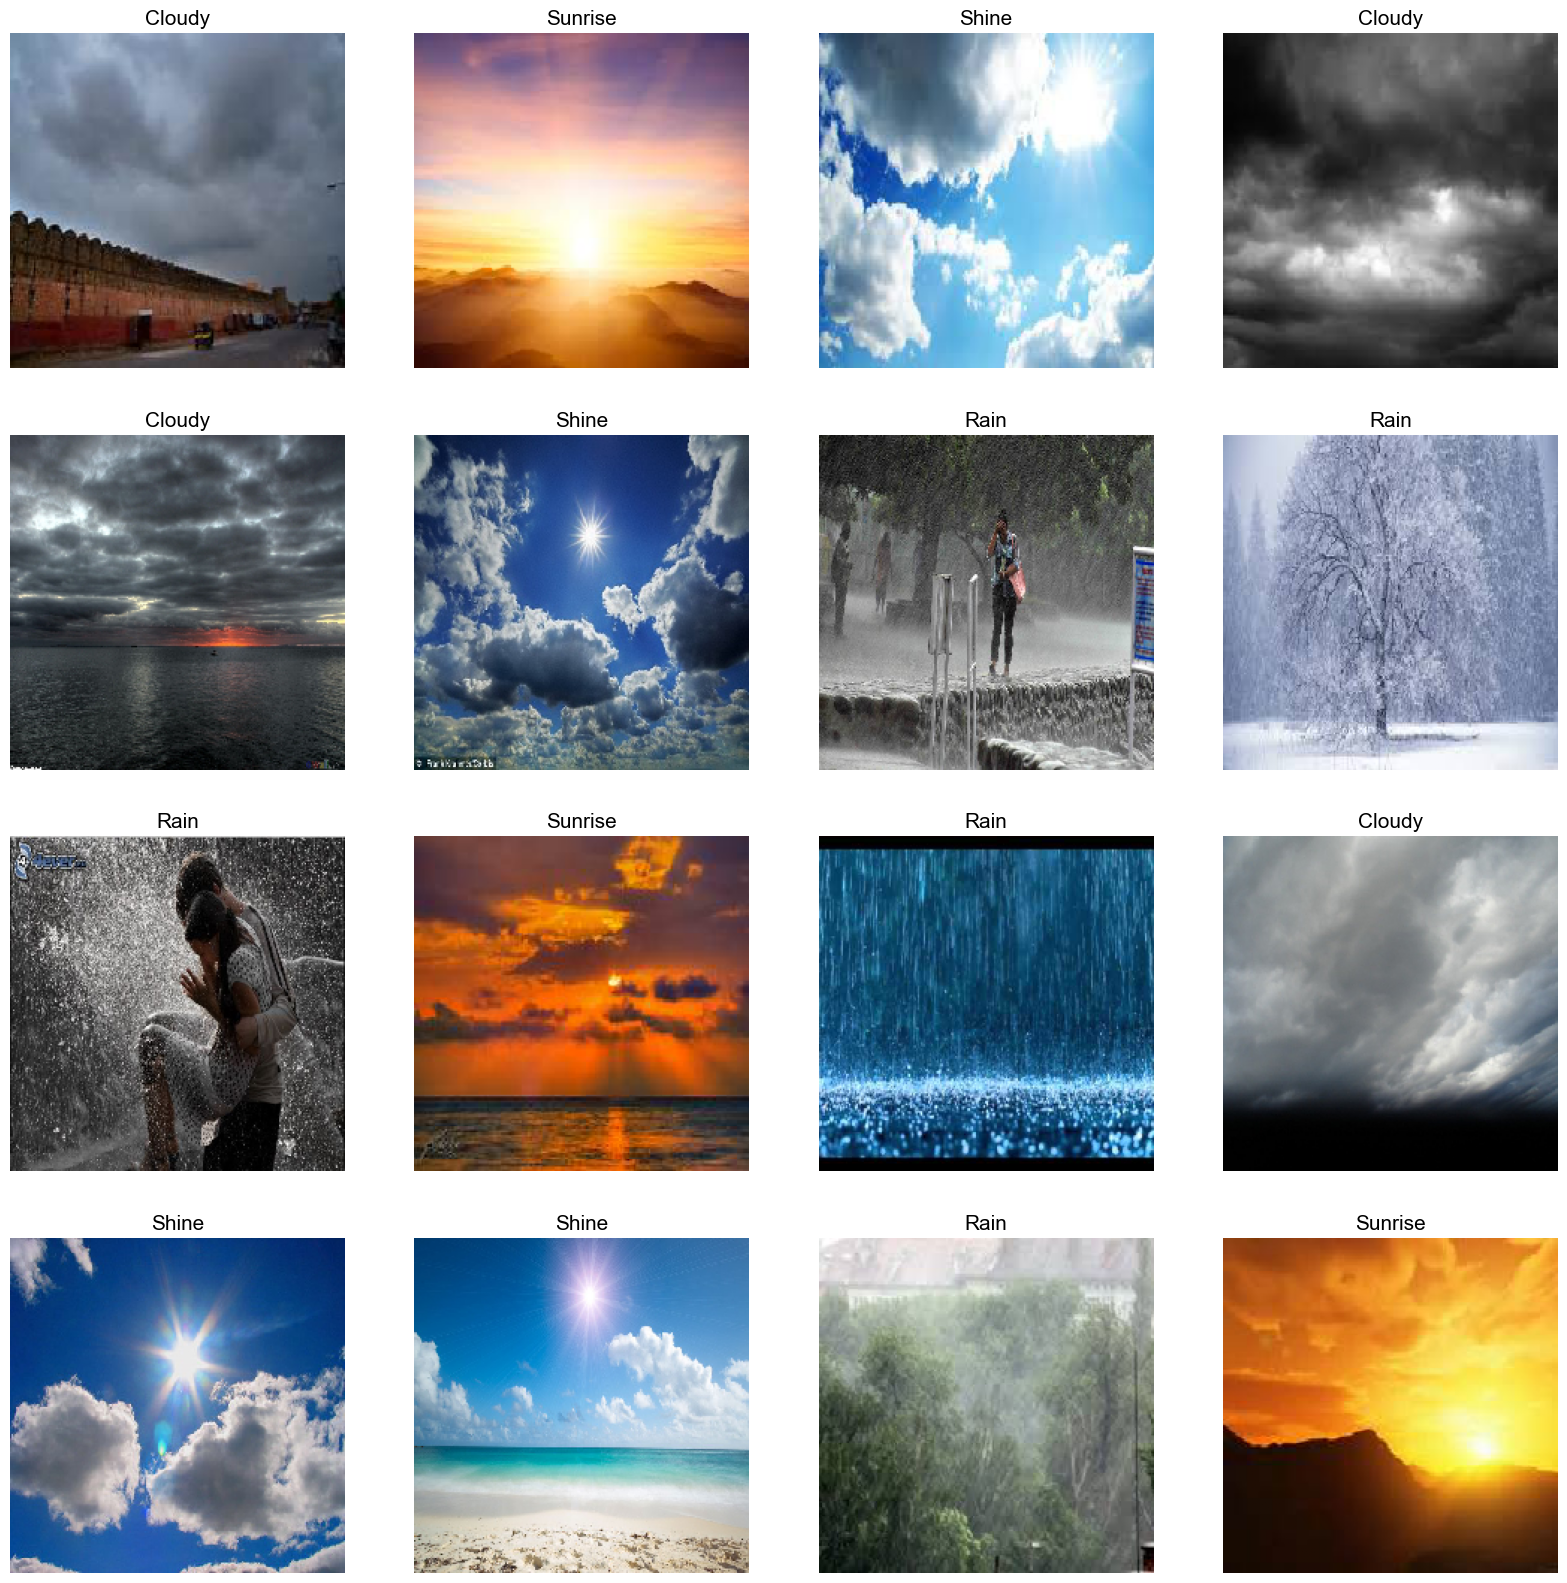

In [9]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)      

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'black', fontsize= 15)
    plt.axis('off')
plt.show()

In [10]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", 
                                                               input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', 
              metrics= ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
                        tf.keras.metrics.AUC()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11184179 (42.66 MB)
Trainable params: 1109

In [11]:
epochs = 25

hist = model.fit(train_gen, epochs = epochs, verbose = 1, validation_data = valid_gen, shuffle = True)

Epoch 1/25
53/53 [==============================] - 307s 5s/step - loss: 8.0959 - accuracy: 0.7675 - precision: 0.7962 - recall: 0.7461 - auc: 0.9383 - val_loss: 8.2498 - val_accuracy: 0.7943 - val_precision: 0.8043 - val_recall: 0.7872 - val_auc: 0.9384
Epoch 2/25
53/53 [==============================] - 256s 5s/step - loss: 6.8231 - accuracy: 0.9478 - precision: 0.9531 - recall: 0.9407 - auc: 0.9933 - val_loss: 6.5246 - val_accuracy: 0.9645 - val_precision: 0.9643 - val_recall: 0.9574 - val_auc: 0.9983
Epoch 3/25
53/53 [==============================] - 250s 5s/step - loss: 6.0017 - accuracy: 0.9656 - precision: 0.9687 - recall: 0.9549 - auc: 0.9964 - val_loss: 5.8088 - val_accuracy: 0.9574 - val_precision: 0.9574 - val_recall: 0.9574 - val_auc: 0.9992
Epoch 4/25
53/53 [==============================] - 245s 5s/step - loss: 5.2764 - accuracy: 0.9668 - precision: 0.9759 - recall: 0.9597 - auc: 0.9984 - val_loss: 5.0759 - val_accuracy: 0.9929 - val_precision: 0.9928 - val_recall: 0.978

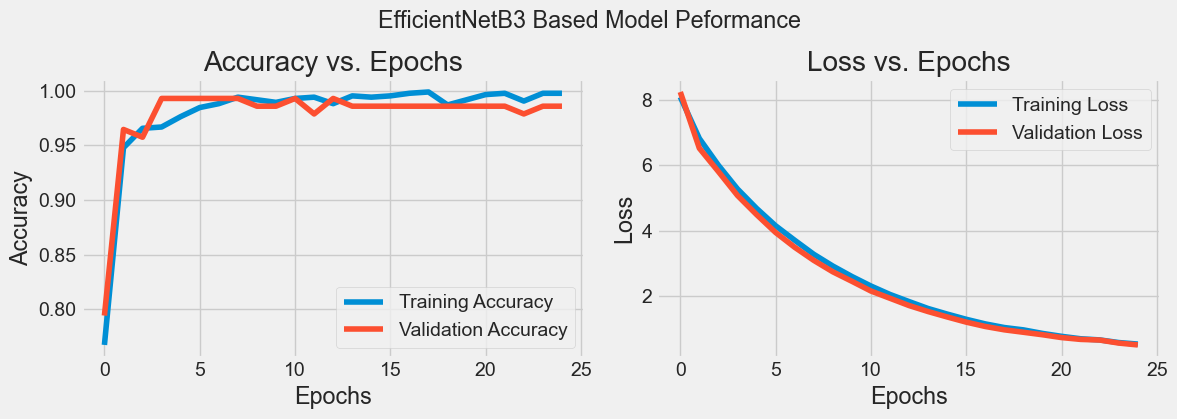

In [61]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy vs. Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss vs. Epochs")
plt.legend()
plt.tight_layout()
plt.suptitle('EfficientNetB3 Based Model Peformance', y = 1.05)
plt.show()

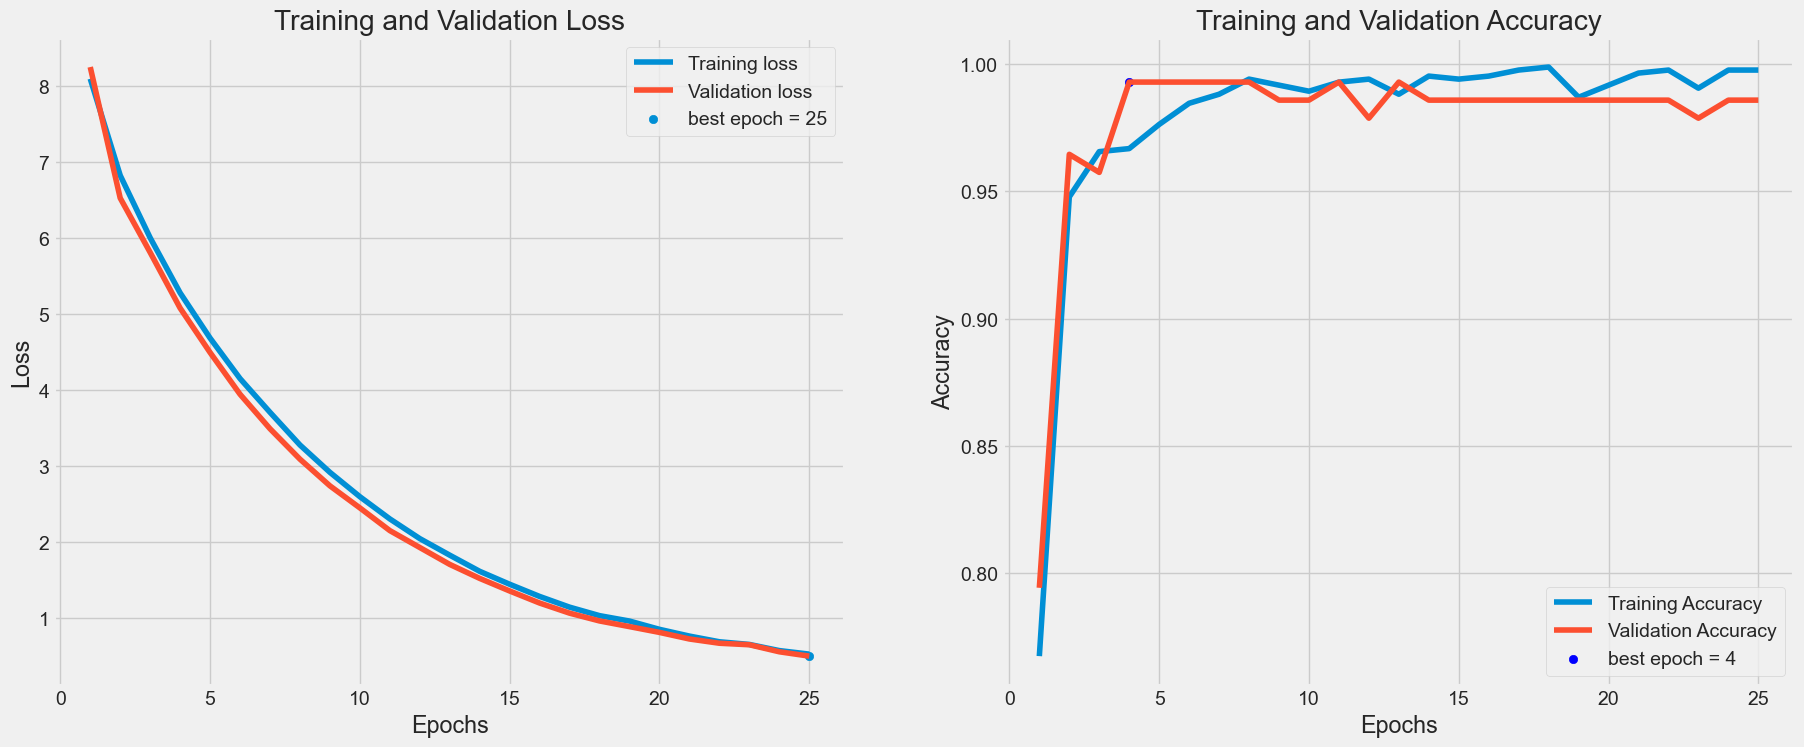

In [57]:
# Define needed variables

tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch = {str(index_loss + 1)}'
acc_label = f'best epoch = {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize=(20, 8))


plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, label = 'Training loss')
plt.plot(Epochs, val_loss, label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [13]:
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

9/9 [==============================] - 10s 1s/step - loss: 0.4775 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000


In [14]:
print('Train Loss : ', train_score[0])
print('Train Accuracy : ', train_score[1])
print('=' * 20)
print( )
print('Valid Loss : ', valid_score[0])
print('Valid Accuracy : ', valid_score[1])
print('=' * 20)
print( )
print('Test Loss : ', test_score[0])
print('Test Accuracy : ', test_score[1])

Train Loss :  0.4603080749511719
Train Accuracy :  1.0

Valid Loss :  0.4935508370399475
Valid Accuracy :  0.9858155846595764

Test Loss :  0.4775274395942688
Test Accuracy :  1.0


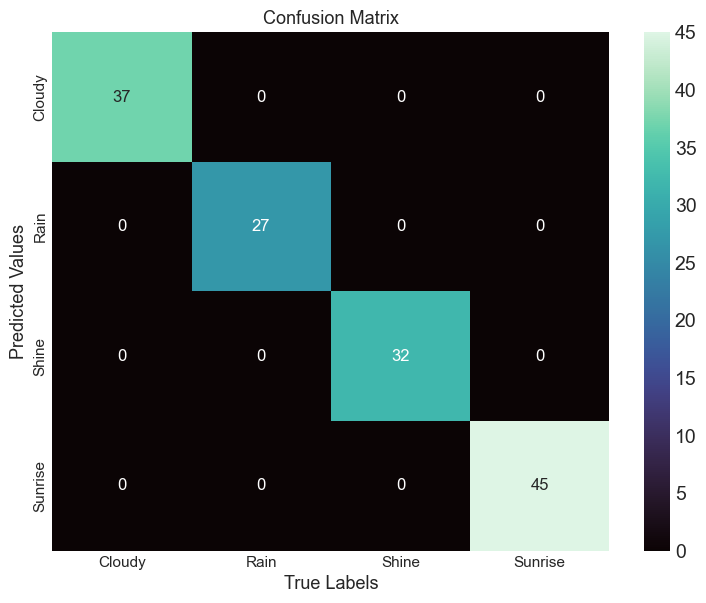

In [48]:
preds = model.predict_generator(test_gen)
y_pred= np.argmax(preds,axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())
#
# Compute confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6.4), facecolor='w')
sns.heatmap(cm, annot=True, fmt='d', cmap='mako',annot_kws={"size": 12})

tick_marks = np.arange(len(classes))
plt.title('Confusion Matrix',fontsize=13)
plt.ylabel('Predicted Values',fontsize=13)
plt.xlabel('True Labels',fontsize=13)

# Adjust tick positions
plt.gca().set_yticklabels(classes, rotation=90,fontsize=11)
plt.gca().set_xticklabels(classes, rotation=0, fontsize=11)

 # Adjust layout for better spacing
plt.show()

In [16]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

In [17]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))


              precision    recall  f1-score   support

      Cloudy       1.00      1.00      1.00        37
        Rain       1.00      1.00      1.00        27
       Shine       1.00      1.00      1.00        32
     Sunrise       1.00      1.00      1.00        45

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141

